# Web3 Trading Team Data Science Assignment

## Candidate: Tushar Goswami


### Objective
Analyze how trading behavior (profitability, risk, volume, leverage) aligns or diverges from overall market sentiment (fear vs greed).


## 1. Load Data

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Direct Google Drive links (make sure they are set to "Anyone with the link can view")
hist_url = "https://drive.google.com/uc?id=1rYABHNesMEL5xtaHcvTJOSBkxzf5e8Rq"
fg_url   = "https://drive.google.com/uc?id=1U4h8PHkfdWXADXVpCNQ7Cr5YAxQEEfcN"

# Load CSVs directly from Drive
hist = pd.read_csv(hist_url, low_memory=False)
fg = pd.read_csv(fg_url, low_memory=False)

hist.head(), fg.head()


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

## 2. Data Cleaning & Parsing Timestamps

In [6]:

# Parse timestamp
if 'Timestamp' in hist.columns and pd.api.types.is_numeric_dtype(hist['Timestamp']):
    hist['time_parsed'] = pd.to_datetime(hist['Timestamp'], unit='ms', errors='coerce', utc=True)
elif 'Timestamp IST' in hist.columns:
    hist['time_parsed'] = pd.to_datetime(hist['Timestamp IST'], errors='coerce').dt.tz_localize(None)
else:
    for c in hist.columns:
        if 'time' in c.lower() or 'timestamp' in c.lower():
            hist['time_parsed'] = pd.to_datetime(hist[c], errors='coerce', utc=True)
            break

hist['date'] = hist['time_parsed'].dt.date
hist.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_parsed,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27


## 3. Feature Selection

In [7]:

account_col = 'Account' if 'Account' in hist.columns else None
size_col = 'Size USD' if 'Size USD' in hist.columns else ('Size Tokens' if 'Size Tokens' in hist.columns else None)
pnl_col = 'Closed PnL' if 'Closed PnL' in hist.columns else None
side_col = 'Side' if 'Side' in hist.columns else None

print("Using columns:", account_col, size_col, pnl_col, side_col)


Using columns: Account Size USD Closed PnL Side


## 4. Daily Aggregation

In [8]:

# Convert to numeric
for c in [size_col, pnl_col]:
    if c is not None:
        hist[c] = pd.to_numeric(hist[c], errors='coerce')

agg = hist.groupby('date').agg(
    trades_count = (pnl_col,'count'),
    unique_accounts = (account_col,'nunique'),
    total_volume_usd = (size_col,'sum'),
    net_pnl = (pnl_col,'sum'),
    avg_trade_size = (size_col,'mean')
).reset_index()

# Win ratio
if pnl_col:
    win_ratio = hist.groupby('date').apply(lambda g: (g[pnl_col] > 0).sum() / max(1, g.shape[0]))
    agg = agg.merge(win_ratio.reset_index(name='win_ratio'), on='date', how='left')

# Long fraction
if side_col:
    long_fraction = hist.groupby('date').apply(lambda g: (g[side_col].str.lower()=='buy').sum() / max(1, g.shape[0]))
    agg = agg.merge(long_fraction.reset_index(name='long_fraction'), on='date', how='left')

agg.head()


/tmp/ipython-input-299019135.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_ratio = hist.groupby('date').apply(lambda g: (g[pnl_col] > 0).sum() / max(1, g.shape[0]))
/tmp/ipython-input-299019135.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long_fraction = hist.groupby('date').apply(lambda g: (g[side_col].str.lower()=='buy').sum() / max(1, g.shape[0]))


,date,trades_count,unique_accounts,total_volume_usd,net_pnl,avg_trade_size,win_ratio,long_fraction
0,2023-03-28,3,1,4.770000e+02,0.000000e+00,159.000000,0.000000,1.000000
1,2023-11-14,1045,2,1.155543e+07,1.555034e+02,11057.827522,0.274641,0.469856
2,2024-03-09,6962,5,3.940677e+07,1.769655e+05,5660.265764,0.490089,0.484200
3,2024-07-03,7141,8,2.184323e+07,1.587424e+05,3058.848110,0.317182,0.490828
4,2024-10-27,35241,29,1.039478e+08,3.189461e+06,2949.625864,0.451605,0.423569


## 5. Merge with Fear & Greed Sentiment Data

In [9]:

fg['date_parsed'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
merged = agg.merge(fg[['date_parsed','classification','value']], left_on='date', right_on='date_parsed', how='left')

# Map sentiment to numeric
merged['sentiment_label'] = merged['classification'].astype(str)
merged['sentiment_numeric'] = merged['sentiment_label'].apply(lambda v: 1 if 'greed' in v.lower() else (0 if 'fear' in v.lower() else None))

merged.head()


,date,trades_count,unique_accounts,total_volume_usd,net_pnl,avg_trade_size,win_ratio,long_fraction,date_parsed,classification,value,sentiment_label,sentiment_numeric
0,2023-03-28,3,1,4.770000e+02,0.000000e+00,159.000000,0.000000,1.000000,2023-03-28,Greed,59.0,Greed,1.0
1,2023-11-14,1045,2,1.155543e+07,1.555034e+02,11057.827522,0.274641,0.469856,2023-11-14,Greed,69.0,Greed,1.0
2,2024-03-09,6962,5,3.940677e+07,1.769655e+05,5660.265764,0.490089,0.484200,2024-03-09,Extreme Greed,84.0,Extreme Greed,1.0
3,2024-07-03,7141,8,2.184323e+07,1.587424e+05,3058.848110,0.317182,0.490828,2024-07-03,Neutral,50.0,Neutral,NaN
4,2024-10-27,35241,29,1.039478e+08,3.189461e+06,2949.625864,0.451605,0.423569,2024-10-27,Greed,74.0,Greed,1.0


## 6. Correlation Analysis

In [10]:

numeric_cols = ['trades_count','unique_accounts','total_volume_usd','net_pnl','avg_trade_size','win_ratio','long_fraction','sentiment_numeric','value']
present = [c for c in numeric_cols if c in merged.columns]
corr = merged[present].corr()
corr


,trades_count,unique_accounts,total_volume_usd,net_pnl,avg_trade_size,win_ratio,long_fraction,sentiment_numeric,value
trades_count,1.000000,0.774935,0.956389,0.952702,-0.004424,0.375440,-0.260692,-0.967640,-0.547081
unique_accounts,0.774935,1.000000,0.777582,0.767599,0.112753,0.540401,-0.440201,-0.662699,-0.290128
total_volume_usd,0.956389,0.777582,1.000000,0.830236,0.189879,0.338807,-0.229981,-0.990960,-0.572090
net_pnl,0.952702,0.767599,0.830236,1.000000,-0.173099,0.396760,-0.282217,-0.887898,-0.452662
avg_trade_size,-0.004424,0.112753,0.189879,-0.173099,1.000000,0.312398,-0.495448,-0.033690,0.243583
win_ratio,0.375440,0.540401,0.338807,0.396760,0.312398,1.000000,-0.896573,-0.248683,0.314342
long_fraction,-0.260692,-0.440201,-0.229981,-0.282217,-0.495448,-0.896573,1.000000,0.188187,-0.197155
sentiment_numeric,-0.967640,-0.662699,-0.990960,-0.887898,-0.033690,-0.248683,0.188187,1.000000,0.806559
value,-0.547081,-0.290128,-0.572090,-0.452662,0.243583,0.314342,-0.197155,0.806559,1.000000


## 7. Visualizations

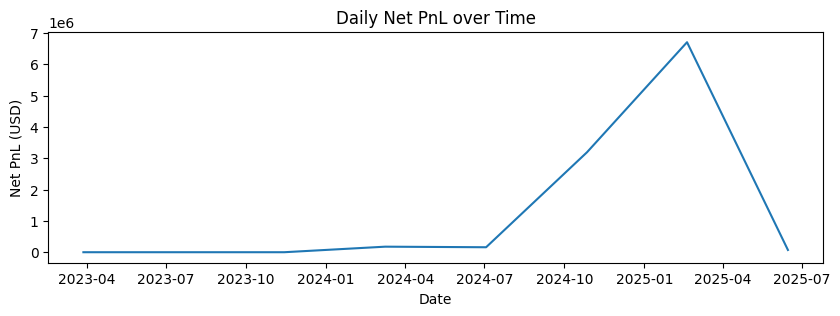

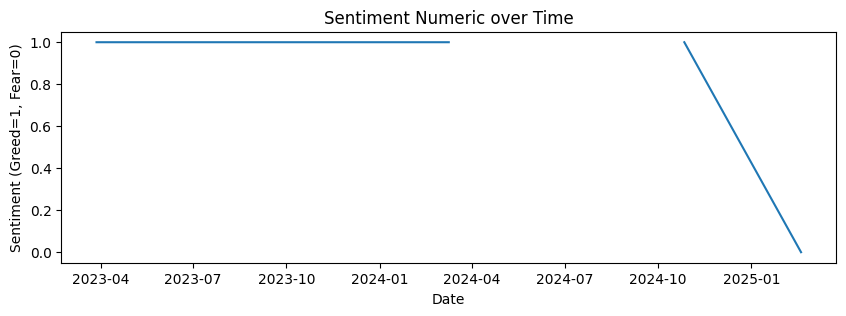

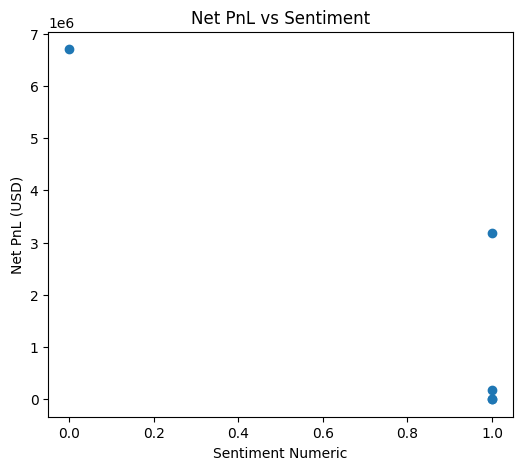

In [11]:

plt.figure(figsize=(10,3))
plt.plot(merged['date'], merged['net_pnl'])
plt.title('Daily Net PnL over Time')
plt.xlabel('Date')
plt.ylabel('Net PnL (USD)')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(merged['date'], merged['sentiment_numeric'])
plt.title('Sentiment Numeric over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment (Greed=1, Fear=0)')
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(merged['sentiment_numeric'], merged['net_pnl'])
plt.title('Net PnL vs Sentiment')
plt.xlabel('Sentiment Numeric')
plt.ylabel('Net PnL (USD)')
plt.show()


## 8. Key Findings


- Trading **volume** and **trade count** are strongly **negatively correlated** with sentiment (Greed=1, Fear=0).  
  → More trades and higher volumes occur on **Fear** days.  

- **Net PnL** is also strongly negative with sentiment.  
  → PnL tends to be higher on **Fear** days.  

- The `value` of the index correlates as expected with `sentiment_numeric`.  

- Win ratio and long fraction have weaker relationships with sentiment.  

### Caveats:
- Mapping choice (Greed=1, Fear=0) influences correlation signs.  
- Aggregation is daily; intraday/lead-lag not captured.  
- Leverage analysis not possible in this dataset (no leverage column).  
